In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

from itertools import permutations

import seaborn as sns

from keras.datasets import mnist
from sklearn.manifold import TSNE

from sklearn.svm import SVC


In [2]:
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
with open('Data/sub_dataset_list.pkl', 'rb') as f:
    smellKey_list = pickle.load(f)
smellKey_list

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
95    14.0
96    14.0
97    14.0
98    14.0
99    14.0
Name: smellKey_encoded, Length: 100, dtype: float64

In [4]:
save_path = 'Data/fn_smell_embeddings_with_triplet.pt'
loaded_ast_embeddings = torch.load(save_path)
loaded_ast_embeddings = loaded_ast_embeddings.numpy()
loaded_ast_embeddings.shape

(100, 768)

In [5]:
data = pd.DataFrame({
    'fn_smell_embeddings.pt': loaded_ast_embeddings.tolist(),
    'smellKey_encoded': smellKey_list
})

X = np.array(data['fn_smell_embeddings.pt'].tolist())
y = np.array(data['smellKey_encoded'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X.shape

(100, 768)

In [6]:
X.shape

(100, 768)

In [7]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
x_test.shape

(20, 768)

In [9]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [10]:
x_train_flat = x_train
x_test_flat = x_test
print(x_train.shape)
print(x_train_flat.shape)

(80, 768)
(80, 768)


IndexError: index 10 is out of bounds for axis 0 with size 10

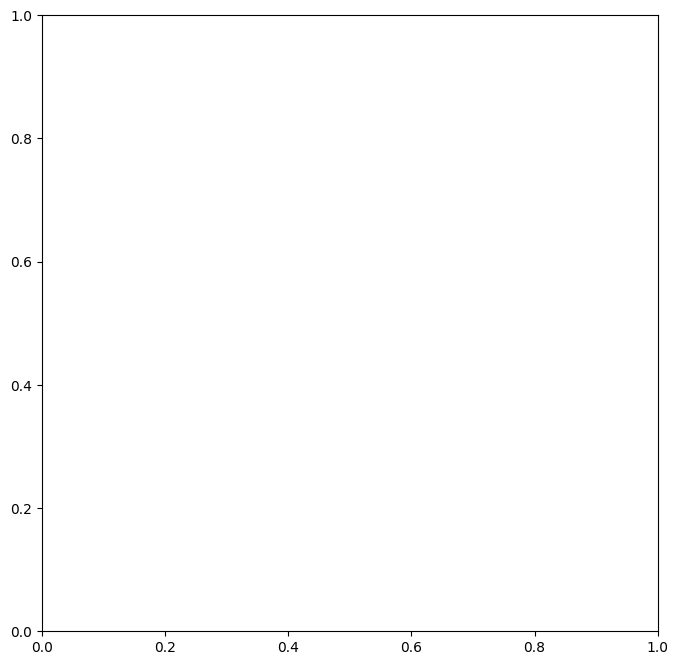

In [11]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

In [12]:
Classifier_input = Input((768,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

In [13]:
from sklearn.preprocessing import LabelBinarizer

In [14]:
le = LabelBinarizer()

In [15]:
y_train_onehot = le.fit_transform(y_train)
y_test_onehot = le.transform(y_test)

In [16]:
Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
x_train_flat.shape

(80, 768)

In [18]:
Classifier_model.fit(x_train_flat,y_train_onehot, validation_data=(x_test_flat,y_test_onehot),epochs=50)

Epoch 1/50
3/3 [==============================] - 1s 77ms/step - loss: 2.3876 - accuracy: 0.1375 - val_loss: 2.4313 - val_accuracy: 0.1000
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 2.1830 - accuracy: 0.2125 - val_loss: 2.4130 - val_accuracy: 0.1500
Epoch 3/50
3/3 [==============================] - 0s 12ms/step - loss: 2.0952 - accuracy: 0.2875 - val_loss: 2.3458 - val_accuracy: 0.1000
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 2.0058 - accuracy: 0.3125 - val_loss: 2.2864 - val_accuracy: 0.2000
Epoch 5/50
3/3 [==============================] - 0s 15ms/step - loss: 1.8986 - accuracy: 0.4125 - val_loss: 2.2429 - val_accuracy: 0.2000
Epoch 6/50
3/3 [==============================] - 0s 15ms/step - loss: 1.7967 - accuracy: 0.5250 - val_loss: 2.1943 - val_accuracy: 0.2500
Epoch 7/50
3/3 [==============================] - 0s 16ms/step - loss: 1.7193 - accuracy: 0.6500 - val_loss: 2.1629 - val_accuracy: 0.2500
Epoch 8/50
3/3 [===========

In [19]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [20]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=30, an_pairs=30,testsize=0.2)
X_train.shape

(7200, 3, 768)

## Triplet NN

In [21]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [22]:
def create_base_network():
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Flatten(input_shape=(768,1)))
    # model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    # model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    # model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    # model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    # model.add(Flatten(name='flatten'))
    model.add(Dense(768,name='embeddings'))
    # model.add(Dense(600))
    
    return model

In [23]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [24]:
anchor_input = Input((768,1), name='anchor_input')
positive_input = Input((768,1 ), name='positive_input')
negative_input = Input((768,1 ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network()


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 768, 1)]     0           []                               
                                                                                                  
 positive_input (InputLayer)    [(None, 768, 1)]     0           []                               
                                                                                                  
 negative_input (InputLayer)    [(None, 768, 1)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 768)          590592      ['anchor_input[0][0]',           
                                                                  'positive_input[0][0]',   

In [26]:
X_train.shape

(7200, 3, 768)

In [27]:
Anchor = X_train[:,0,:].reshape(-1,768,1)
Positive = X_train[:,1,:].reshape(-1,768,1)
Negative = X_train[:,2,:].reshape(-1,768,1)
Anchor_test = X_test[:,0,:].reshape(-1,768,1)
Positive_test = X_test[:,1,:].reshape(-1,768,1)
Negative_test = X_test[:,2,:].reshape(-1,768,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=500)

Epoch 1/500
y_pred.shape =  Tensor("model_1/merged_layer/concat:0", shape=(None, 2304), dtype=float32)
y_pred.shape =  Tensor("model_1/merged_layer/concat:0", shape=(None, 2304), dtype=float32)
15/15 [==============================] - 1s 54ms/step - loss: 2.5095 - val_loss: 1.0319
Epoch 2/500
15/15 [==============================] - 1s 42ms/step - loss: 0.1578 - val_loss: 0.7343
Epoch 3/500
15/15 [==============================] - 1s 42ms/step - loss: 0.0749 - val_loss: 0.6154
Epoch 4/500
15/15 [==============================] - 1s 42ms/step - loss: 0.0525 - val_loss: 0.6452
Epoch 5/500
15/15 [==============================] - 1s 39ms/step - loss: 0.0603 - val_loss: 0.7221
Epoch 6/500
15/15 [==============================] - 1s 43ms/step - loss: 0.0508 - val_loss: 0.6975
Epoch 7/500
15/15 [==============================] - 1s 41ms/step - loss: 0.0354 - val_loss: 0.7264
Epoch 8/500
15/15 [==============================] - 1s 40ms/step - loss: 0.0281 - val_loss: 0.7627
Epoch 9/500
15/15 

In [28]:
predict_ready_data = loaded_ast_embeddings.reshape(-1,768,1)
predict_ready_data.shape

(100, 768, 1)

In [29]:
predictedModel = model.predict([predict_ready_data, predict_ready_data, predict_ready_data])

4/4 [==============================] - 0s 2ms/step


In [31]:
predictedModel.shape

(100, 2304)

In [32]:
outputAnchor = predictedModel[:, :768]


In [38]:
X[0]

array([ 5.30531593e-02,  7.21399009e-01,  5.73245108e-01,  3.63488466e-01,
        8.37056518e-01, -5.88767350e-01,  1.34191561e+00,  1.34519681e-01,
       -1.37897059e-01,  9.78766143e-01, -8.29323649e-01,  6.36339664e-01,
       -7.44484663e-02,  7.21939802e-01, -5.63872218e-01,  2.30193630e-01,
       -6.67314708e-01, -8.93377364e-01,  1.23766375e+00, -2.69494474e-01,
       -1.81013867e-02, -4.71434116e-01, -5.78870118e-01, -2.86064565e-01,
        1.19328403e+00,  4.56193030e-01, -2.28490576e-01, -6.42638862e-01,
       -1.71555269e+00,  1.67028338e-01, -5.70156753e-01, -3.65860879e-01,
        5.34271240e-01,  1.06910303e-01, -1.77924946e-01,  3.41371626e-01,
        2.21525356e-01,  1.26615763e-01,  4.47818846e-01,  5.47480583e-02,
        4.31222349e-01, -3.51558715e-01,  7.44501591e-01,  4.24757693e-03,
       -1.08954608e+00, -6.50323153e-01,  1.32380739e-01,  1.81998983e-01,
        4.80778724e-01, -2.93770969e-01, -1.32629931e+00,  1.10504031e+00,
        1.13006413e+00,  

In [39]:
outputAnchor[0]

array([ 1.04101956e+00, -9.22686979e-02, -3.32211524e-01,  1.99673578e-01,
       -7.69471843e-03,  1.52403247e+00, -6.44789875e-01, -1.07664216e+00,
        1.70765072e-01, -3.68559241e-01,  8.93172979e-01, -4.50514793e-01,
       -1.19771802e+00,  9.17791545e-01, -3.15983683e-01, -3.66473049e-01,
        2.45225072e+00, -2.18654588e-01, -6.56809628e-01, -1.06306446e+00,
        4.48867679e-01,  2.28784084e-01, -6.71260715e-01, -6.20196402e-01,
        1.05643892e+00, -3.80660236e-01,  6.84267819e-01,  2.03097731e-01,
       -3.18890810e+00,  2.19999269e-01,  1.27515495e-01,  8.27168643e-01,
       -1.45578170e+00,  1.46845973e+00,  1.15233517e+00,  6.39650106e-01,
       -6.14069887e-02, -1.87364995e+00,  1.63796377e+00,  2.28171253e+00,
        1.25179482e+00, -4.96792555e-01, -1.20025134e+00,  7.07903579e-02,
        2.65869856e-01, -2.40666449e-01,  7.98124373e-02, -1.76189983e+00,
        7.71629205e-03, -1.07935655e+00,  9.15472984e-01, -2.17511086e-03,
       -1.93477631e+00,  

In [33]:
outputAnchor.shape

(100, 768)

In [35]:
x_train, x_test, y_train, y_test = train_test_split(outputAnchor, y, test_size=0.2, random_state=42)

In [36]:
Classifier_model.fit(x_train_flat,y_train_onehot, validation_data=(x_test_flat,y_test_onehot),epochs=50)

Epoch 1/50
3/3 [==============================] - 0s 28ms/step - loss: 0.4673 - accuracy: 0.9750 - val_loss: 1.6052 - val_accuracy: 0.4500
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 0.4591 - accuracy: 0.9625 - val_loss: 1.6085 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 13ms/step - loss: 0.4488 - accuracy: 0.9625 - val_loss: 1.6086 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 13ms/step - loss: 0.4380 - accuracy: 0.9625 - val_loss: 1.6014 - val_accuracy: 0.4500
Epoch 5/50
3/3 [==============================] - 0s 12ms/step - loss: 0.4267 - accuracy: 0.9625 - val_loss: 1.5914 - val_accuracy: 0.4500
Epoch 6/50
3/3 [==============================] - 0s 14ms/step - loss: 0.4209 - accuracy: 0.9750 - val_loss: 1.5874 - val_accuracy: 0.4500
Epoch 7/50
3/3 [==============================] - 0s 11ms/step - loss: 0.4133 - accuracy: 0.9750 - val_loss: 1.5815 - val_accuracy: 0.4500
Epoch 8/50
3/3 [===========